Neural Simulation of a CognitiveModel for Visual SearchVisual 

In [23]:
%matplotlib inline  
import numpy as np
import pandas as pd
import ast
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle, Circle

In [24]:
df = pd.read_csv(os.path.join('data', 'salicon/simulations', 'salicon_actr.csv'))

# convert str to list of lists
df['image_data'] = df['image_data'].map(ast.literal_eval)
df['object_info'] = df['object_info'].map(ast.literal_eval)
df['actr_data'] = df['actr_data'].map(ast.literal_eval)
df['actr_data_processed'] = df['actr_data_processed'].map(ast.literal_eval)

actr_image_data = df.to_numpy()

In [25]:
# draw the actr simualtion
def draw_actr_image(filename, image_info, sim_info, gaze_info, circle_rad=None, circle_alpha=0.4, ax=None, show_path=False, show_objects=False):
	if ax is None:
		ax = plt.gca()
	data = mpimg.imread(filename)
	# plot each box
	for i in range(len(image_info)):

		if show_objects:
			obj = image_info[i]
			y1, x1, y2, x2 = obj[5], obj[3], obj[4], obj[2]
			width, height = x2 - x1, y2 - y1
			rect = Rectangle((x1, y1), width, height, fill=False, color='white', alpha=0.3)
			ax.add_patch(rect)
			label = "%s (%.3f)" % (obj[0], obj[1])
			ax.text(x1, y1, label, color='white')

		gz = gaze_info[i]
		sim = sim_info[i]
		midx, midy, area, delay = gz[0], gz[1], sim[4], sim[5]
		if circle_rad is None:
			rad = area * 0.5
		circle = Circle((midx, midy), radius=circle_rad, fill=True, color='blue', alpha=circle_alpha)
		ax.add_patch(circle)
		label = "%s (%.3f)" % (i, gz[2])
		ax.text(midx, midy, label, color='white')

		if show_path and i < len(image_info)-1:
			ax.arrow(gaze_info[i][0], gaze_info[i][1], gaze_info[i+1][0] - gaze_info[i][0],\
				gaze_info[i+1][1] - gaze_info[i][1], length_includes_head=False, head_width=0.8)
	ax.imshow(data)
	return ax
		
	# pyplot.show()

In [26]:
# draw ground truth fixations
def draw_fixations(image, x, y, timestamp=None, ax=None, show_path=False):
    if ax is None:
        ax = plt.gca()

    data = mpimg.imread(image)
    ax.imshow(data)
    # cast to support negative values
    x, y = x.astype(np.int16), y.astype(np.int16)

    for i, txt in enumerate(range(len(x))):
        if timestamp is not None:
            label = "%s (%.3f)" % (i, timestamp[i])
            ax.annotate(label, (x[i], y[i]), color='white')
        else:
            ax.annotate(i, (x[i], y[i]), color='white')
        if show_path and i < len(x)-1:
            ax.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], length_includes_head=False, head_width=0.8)
    ax.scatter(x, y, s=100, color='blue');
    return ax

In [27]:
# draw the ground fixation map
def draw_fixation_map(image, ax=None):
    if ax is None:
        ax = plt.gca()
    data = mpimg.imread(image)
    ax.imshow(data)
    return ax

In [28]:
# get eyegaze data
def get_eye_gaze_data(matfile, no_subjects=1, subject=None):
    import scipy.io
    gaze_data_all = {'gaze': [], 'timestamp':[], 'fixations':[]}
    fix_mat = scipy.io.loadmat(os.path.splitext(fixation_file)[0])
    gaze_data = fix_mat['gaze']
    fixations = gaze_data['fixations']
    x_fix = np.empty(fixations.shape, int)
    y_fix = np.empty(fixations.shape, int)

    if subject is not None:
        gaze = gaze_data[subject]
        x_fix, y_fix = gaze[0][2][:,0], gaze[0][2][:,1]
        gaze_data_all = {
            'gaze': [gaze[0][0][:,0], gaze[0][0][:,1]],
            'timestamp': gaze[0][1][:,0],
            'fixations': [gaze[0][2][:,0], gaze[0][2][:,1]]
        }
    else:
        x_fix = []
        y_fix = []
        timestamp = []
        x_gaze = []
        y_gaze = []
        no_subjects = gaze_data.shape[0]
        for i in range(no_subjects):
            gaze = gaze_data[i]
            x_fix.append(gaze[0][2][:,0])
            x_gaze.append(gaze[0][0][:,0])
            y_fix.append(gaze[0][2][:,1])
            y_gaze.append(gaze[0][0][:,1])
            timestamp.append(gaze[0][1][:,0])
        
        gaze_data_all['gaze'] = [x_gaze, y_gaze]
        gaze_data_all['timestamp'] = timestamp
        gaze_data_all['fixations'] = [x_fix, y_fix]

    return gaze_data_all

In [29]:
SET = "val"
IMAGE_ROOT = os.path.join('data', 'salicon/images', SET)
FIXATION_ROOT = os.path.join('data', 'salicon/fixations', SET)
MAPS_ROOT = os.path.join('data', 'salicon/maps', SET)

To analyse our model visually, we will take a random sample from the processed data and a random subject from the SALICON dataset.
The following block can be modified to select distinct sample point, and subject from the dataset.

In [30]:
# take a random sample and subject
sample_data = actr_image_data[521]
subject = 11

# assign filenames
image_file = os.path.join(IMAGE_ROOT, sample_data[0])
fixation_file = os.path.splitext(os.path.join(FIXATION_ROOT, sample_data[0]))[0] + '.mat'
heat_map_file = os.path.splitext(os.path.join(MAPS_ROOT, sample_data[0]))[0] + '.png'

<AxesSubplot:>

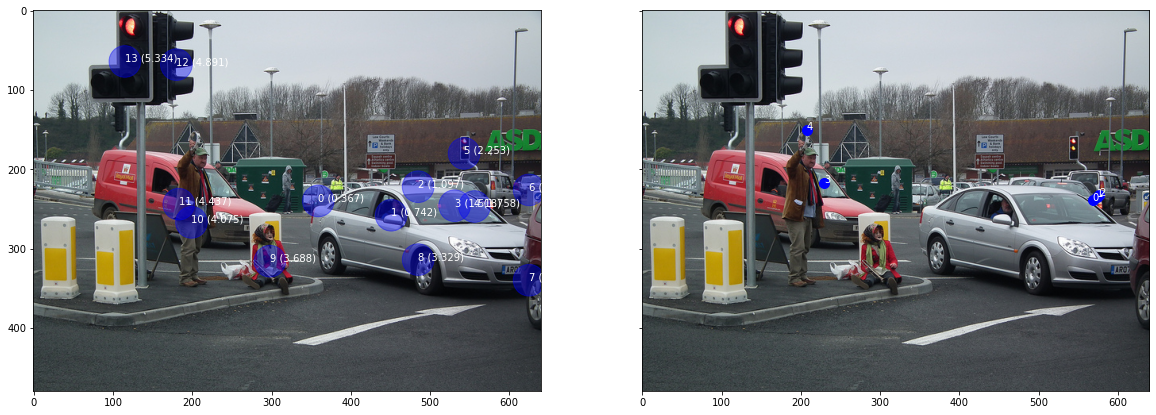

In [31]:
# get gaze data 
gaze_data = get_eye_gaze_data(fixation_file, subject=subject)
x, y = gaze_data['fixations']
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))
draw_actr_image(image_file, sample_data[1], sample_data[2], sample_data[4], ax=ax1, circle_rad=20)
draw_fixations(image_file, x, y)

<AxesSubplot:>

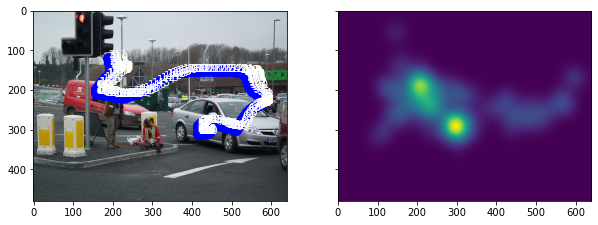

In [32]:
# get the raw gaze data
x, y = gaze_data['gaze']
gaze_durations = gaze_data['timestamp']
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))

# plot the raw gaze points, ground truth fixation map on the image 
draw_fixations(image_file, x, y, ax=ax1)
draw_fixation_map(heat_map_file, ax=ax2)

For comparing the results with ground truth data, we read the fixation file provided by the SALICON dataset and perform the k-mean clustering on the fixation points with number of clusters based on the number of detected object in our actr model.

Then for each gaze points in the cluster we calculate the average timestamp of the cluster and compare with gaze timestamps from the actr model  

Note: The calculated fixations timestamps represent the average timestamps of raw gaze, hence the difference with the actr model

<AxesSubplot:>

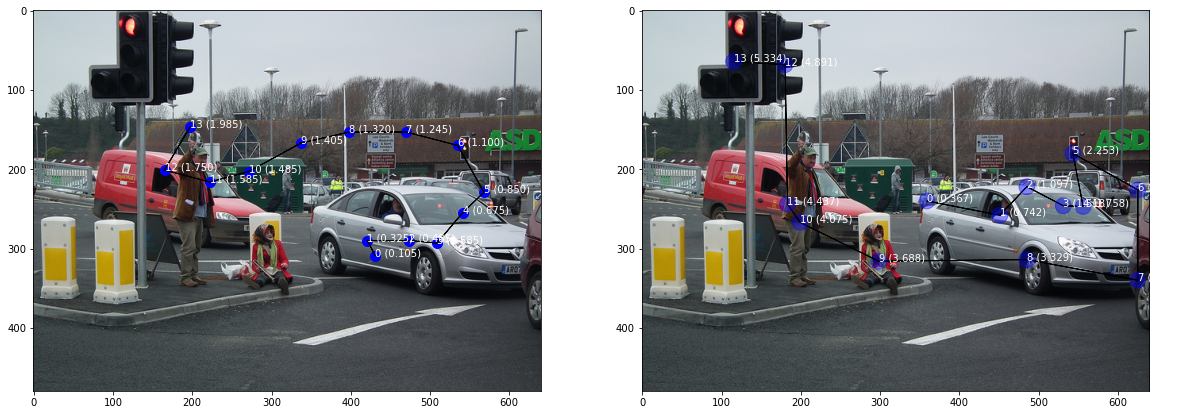

In [37]:
from sklearn.cluster import KMeans
K = len(sample_data[1])

# cluster raw gaze points and get timestamps 
X = [(x, y) for x, y in zip(x,y)]
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
centers = kmeans.cluster_centers_
gazedict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
times = np.array([np.mean(value)/100 for key, value in gazedict.items()])
# get indices based on timestamp
indices = times.argsort()
# rearrange the cluster centers
centers = centers[indices]
times = np.sort(times)
# draw fixations
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,10))
draw_fixations(image_file, centers[:,0] , centers[:,1], times, ax=ax1, show_path=True)
draw_actr_image(image_file, sample_data[1], sample_data[2], sample_data[4], circle_rad=10, ax=ax2, show_path=True)
